In [1]:
# Import required Libraries
import zipfile
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Load the Dataset
df = pd.read_csv("IMDb Movies India.csv", encoding='ISO-8859-1')

In [4]:
# Explore the dataset
df.head()

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,NaN,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
1,#Gadhvi (He thought he was Gandhi),-2019.0,109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,#Homecoming,-2021.0,90 min,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,#Yaaram,-2019.0,110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,...And Once Again,-2010.0,105 min,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali


In [5]:
# Explore and Clean the Data
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      15509 non-null  object 
 1   Year      14980 non-null  float64
 2   Duration  7241 non-null   object 
 3   Genre     13632 non-null  object 
 4   Rating    7919 non-null   float64
 5   Votes     7920 non-null   object 
 6   Director  14984 non-null  object 
 7   Actor 1   13892 non-null  object 
 8   Actor 2   13124 non-null  object 
 9   Actor 3   12356 non-null  object 
dtypes: float64(2), object(8)
memory usage: 1.2+ MB


Name           0
Year         529
Duration    8268
Genre       1877
Rating      7590
Votes       7589
Director     525
Actor 1     1617
Actor 2     2385
Actor 3     3153
dtype: int64

In [6]:
# Clean the raw data and Handle Missing Values
df = df.drop(index=0).reset_index(drop=True)
df = df[df['Rating'].notna()]
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
df['Votes'] = df['Votes'].str.replace(',', '', regex=False)
df['Votes'] = pd.to_numeric(df['Votes'], errors='coerce')
df['Duration'] = df['Duration'].str.extract(r'(\d+)').astype(float)

In [7]:
for col in ['Year', 'Votes', 'Duration']:
    df[col] = df[col].fillna(df[col].median())

for col in ['Genre', 'Director', 'Actor 1', 'Actor 2', 'Actor 3']:
    df[col] = df[col].fillna("Unknown")


In [8]:
# Preview Clean Data
print("Cleaned Data Info:")
print(df.info())
print("\n Sample Data:")
print(df.head())

Cleaned Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 7919 entries, 0 to 15507
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      7919 non-null   object 
 1   Year      7919 non-null   float64
 2   Duration  7919 non-null   float64
 3   Genre     7919 non-null   object 
 4   Rating    7919 non-null   float64
 5   Votes     7919 non-null   float64
 6   Director  7919 non-null   object 
 7   Actor 1   7919 non-null   object 
 8   Actor 2   7919 non-null   object 
 9   Actor 3   7919 non-null   object 
dtypes: float64(4), object(6)
memory usage: 680.5+ KB
None

 Sample Data:
                                 Name    Year  Duration  \
0  #Gadhvi (He thought he was Gandhi) -2019.0     109.0   
2                             #Yaaram -2019.0     110.0   
4                ...Aur Pyaar Ho Gaya -1997.0     147.0   
5                           ...Yahaan -2005.0     142.0   
7                  ?: A Question Mark -20

In [9]:
#Reduce Cardinality
for col in ['Director', 'Actor 1', 'Actor 2', 'Actor 3']:
    top_items = df[col].value_counts().nlargest(8).index
    df[col] = df[col].apply(lambda x: x if x in top_items else 'Other')

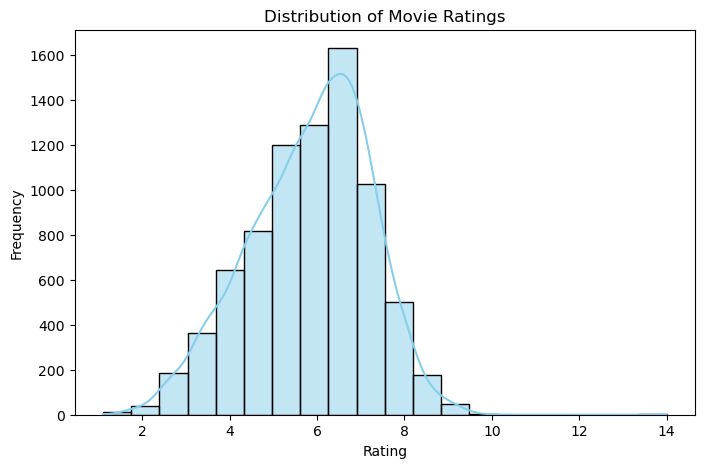

In [10]:
# Rating Distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['Rating'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

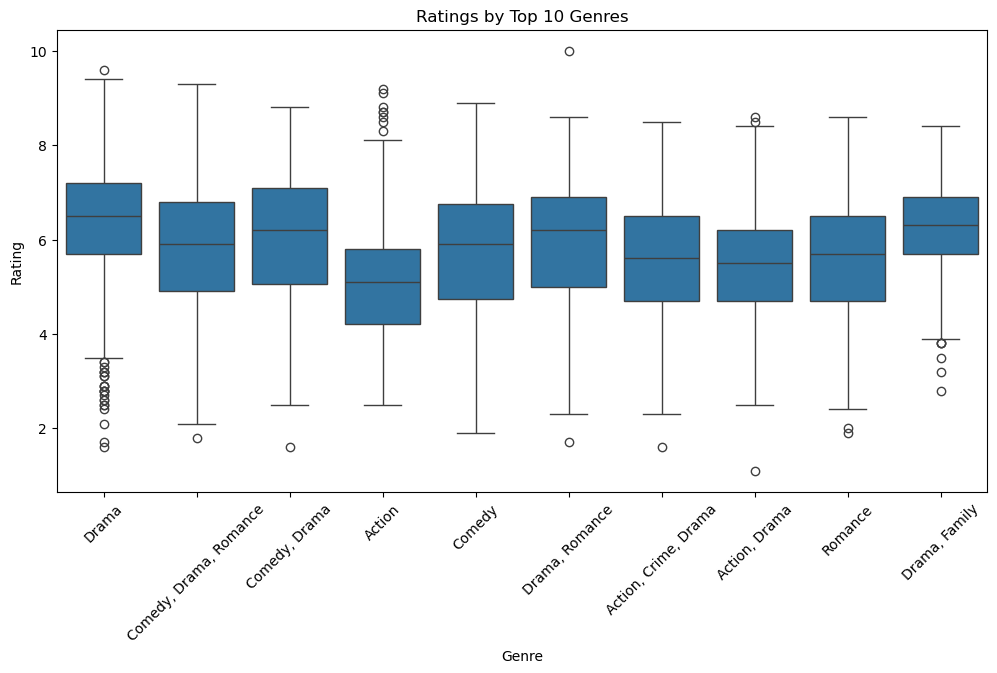

In [11]:
# Boxplot by Top Genres
top_genres = df['Genre'].value_counts().nlargest(10).index
df_top_genres = df[df['Genre'].isin(top_genres)]
plt.figure(figsize=(12, 6))
sns.boxplot(x='Genre', y='Rating', data=df_top_genres)
plt.xticks(rotation=45)
plt.title("Ratings by Top 10 Genres")
plt.show()

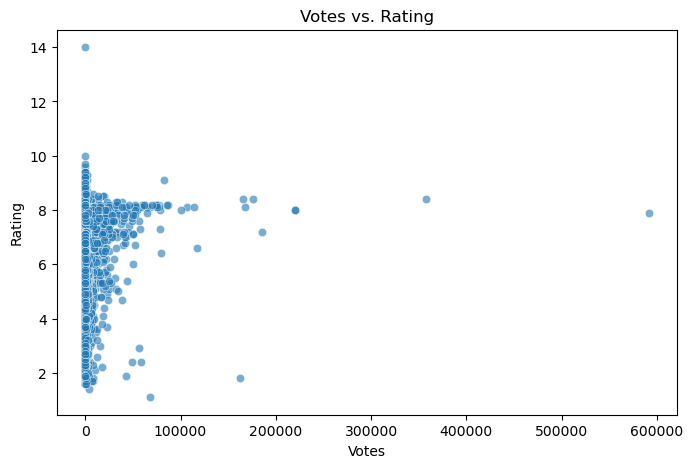

In [12]:
# Scatterplot: Votes vs Rating
plt.figure(figsize=(8, 5))
sns.scatterplot(x='Votes', y='Rating', data=df, alpha=0.6)
plt.title('Votes vs. Rating')
plt.xlabel('Votes')
plt.ylabel('Rating')
plt.show()

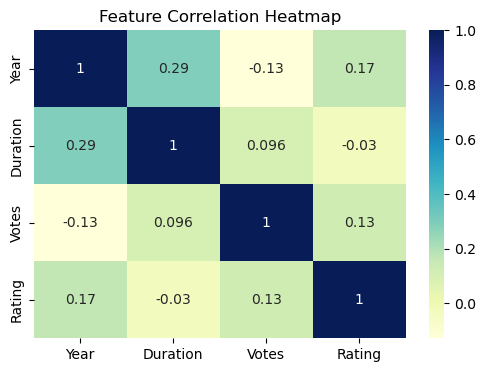

In [13]:
# Correlation Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(df[['Year', 'Duration', 'Votes', 'Rating']].corr(), annot=True, cmap='YlGnBu')
plt.title('Feature Correlation Heatmap')
plt.show()

In [14]:
# Encode Categorical Data
df_model = df[['Genre', 'Director', 'Actor 1', 'Actor 2', 'Actor 3', 'Year', 'Duration', 'Votes', 'Rating']]
df_encoded = pd.get_dummies(df_model, columns=['Genre', 'Director', 'Actor 1', 'Actor 2', 'Actor 3'], drop_first=True)

In [15]:
# Top 10 Actors With Most Movie Involvements
# Combine the three actor columns into one Series
combined_actors = pd.concat([df['Actor 1'], df['Actor 2'], df['Actor 3']])

# Display the top 10 actors
top_10_actors = combined_actors.value_counts().head(10)
top_10_actors

Other                 21545
Unknown                 624
Mithun Chakraborty      231
Dharmendra              189
Jeetendra               140
Ashok Kumar             125
Rajesh Khanna           118
Amitabh Bachchan        117
Dev Anand                91
Rekha                    79
Name: count, dtype: int64

In [16]:
# Train-Test split
X = df_encoded.drop('Rating', axis=1)
y = df_encoded['Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Train the Model
model = RandomForestRegressor(n_estimators=50, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [18]:
# Evaluate the Model
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [19]:
print("\n MODEL EVALUATION RESULTS")
print("-" * 30)
print(f"R² Score       : {r2:.4f}")
print(f"RMSE (Error)   : {rmse:.4f}")
print("-" * 30)



 MODEL EVALUATION RESULTS
------------------------------
R² Score       : 0.3250
RMSE (Error)   : 1.1203
------------------------------


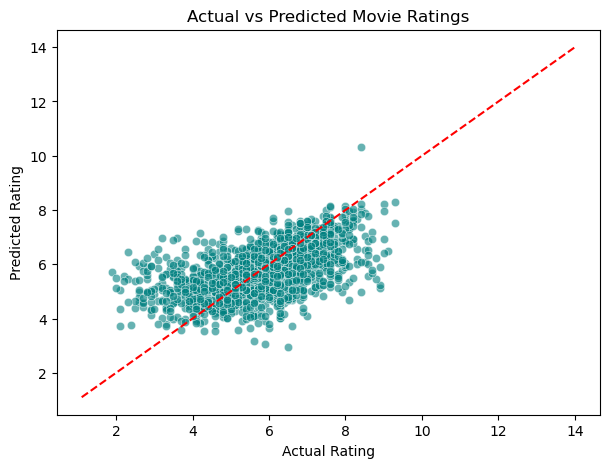

In [20]:
# Actual vs Predicted Movie Ratings
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_test, y=y_pred, color='teal', alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual Rating")
plt.ylabel("Predicted Rating")
plt.title("Actual vs Predicted Movie Ratings")
plt.show()